/home/subuyazem/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Loaded & resampled 1647/1647 airfoils.


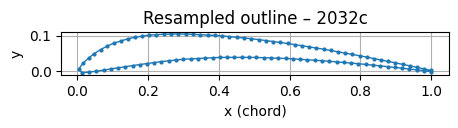


Aero file loaded  ➜  494,100 rows, columns: ['airfoil_name', 'airfoil_file', 'reynolds_number', 'angle_of_attack', 'cl', 'cd', 'cm', 'cl_cd_ratio']


,airfoil_name,airfoil_file,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio
0,2032c,2032c.dat,100000.0,-30,[-0.92836646],[0.33991014],[0.12694423],[-2.73121143]
1,2032c,2032c.dat,100000.0,-29,[-0.90128394],[0.3311661],[0.11906903],[-2.72154647]
2,2032c,2032c.dat,100000.0,-28,[-0.87298586],[0.32208051],[0.11105668],[-2.7104585]
3,2032c,2032c.dat,100000.0,-27,[-0.84350494],[0.31271522],[0.10293745],[-2.6973581]
4,2032c,2032c.dat,100000.0,-26,[-0.81288528],[0.30312549],[0.09474397],[-2.68167909]


In [1]:
# ===== STEP 1 – DATA LOADING & RESAMPLING =====================================
#
# • Reads every *.dat* file in AIRFOIL_DIR
# • Resamples each outline to 100 (x, y) points
# • Stores results in a pandas DataFrame  (airfoil_name, geometry)
# • Optionally previews the first airfoil and the aero-CSV header
# ==============================================================================
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# -----------------------------------------------------------------------------#
# PATH CONFIG – edit these two lines only
AIRFOIL_DIR = "./airfoils"           # folder containing the 1 647 .dat files
AERO_CSV    = "./airfoil_dataset2.csv"  # big CSV with Re, α, Cₗ, C_d, C_m, …
# -----------------------------------------------------------------------------#

def load_dat_file(path: str) -> np.ndarray:
    """
    Read a .dat airfoil file and return an (N, 2) array of raw (x, y) coords.
    Skips the first header line and any malformed rows.
    """
    coords = []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        lines = f.readlines()
    for ln in lines[1:]:
        parts = ln.strip().split()
        if len(parts) >= 2:
            try:
                coords.append([float(parts[0]), float(parts[1])])
            except ValueError:
                continue  # ignore non-numeric lines
    return np.asarray(coords, dtype=np.float32)


def resample_airfoil(coords: np.ndarray, n_points: int = 100) -> np.ndarray:
    """
    Resample a closed airfoil outline to *n_points* along its arc length.
    Returns an (n_points, 2) array.
    """
    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("coords must be an (N, 2) array")

    # cumulative arc-length parameter s ∈ [0, 1]
    deltas   = np.diff(coords, axis=0)
    seglens  = np.sqrt((deltas ** 2).sum(axis=1))
    s        = np.concatenate([[0.0], np.cumsum(seglens)])
    if s[-1] == 0.0:                       # degenerate outline
        raise ValueError("zero total length – cannot resample")
    s /= s[-1]

    new_s = np.linspace(0.0, 1.0, n_points)
    fx, fy = interp1d(s, coords[:, 0]), interp1d(s, coords[:, 1])
    return np.vstack([fx(new_s), fy(new_s)]).T


# ----------  BULK IMPORT  -----------------------------------------------------
airfoil_files = sorted(glob.glob(os.path.join(AIRFOIL_DIR, "*.dat")))
geometries = []

for p in airfoil_files:
    try:
        geom = resample_airfoil(load_dat_file(p))
        geometries.append({
            "airfoil_name": os.path.splitext(os.path.basename(p))[0],
            "geometry"    : geom        # shape (100, 2)
        })
    except Exception as e:
        print(f"[warn] {os.path.basename(p)} skipped – {e}")

df_geo = pd.DataFrame(geometries)
print(f"Loaded & resampled {len(df_geo)}/{len(airfoil_files)} airfoils.")

# ----------  QUICK VISUAL CHECK  ---------------------------------------------
if not df_geo.empty:
    sample = df_geo.iloc[0]
    plt.figure(figsize=(5,4))
    plt.plot(sample["geometry"][:,0], sample["geometry"][:,1],
             marker="o", markersize=2, linewidth=1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Resampled outline – {sample['airfoil_name']}")
    plt.xlabel("x (chord)"); plt.ylabel("y"); plt.grid(True)
    plt.show()

# ----------  OPTIONAL: peek at aerodynamic CSV  ------------------------------
if os.path.exists(AERO_CSV):
    df_aero = pd.read_csv(AERO_CSV)
    print(f"\nAero file loaded  ➜  {df_aero.shape[0]:,} rows, "
          f"columns: {list(df_aero.columns)}")
    display(df_aero.head())
else:
    print("\n[info] AERO_CSV not found – will load later.")


In [2]:
# ===== STEP 2 – BUILD TRAINING DATASET =======================================
#
# • Requires df_geo from Step 1 already in memory
# • Loads the aerodynamic CSV, converts bracketed numbers → float
# • Merges on airfoil_name  → df_train
# • Adds a unique airfoil_id  (0 … 1 646)
# • Saves to disk as airfoil_cvae_dataset.pkl
# ============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

# --------------------------------------------------------------------------- #
# Sanity: make sure Step 1 ran
if "df_geo" not in globals():
    raise RuntimeError("Run Step 1 first – df_geo not found in notebook memory.")

# --------------------------------------------------------------------------- #
# 1. Load and clean the aerodynamic CSV
df_aero = pd.read_csv(AERO_CSV)

# Convert the bracketed strings like "[-0.58353]" → float
num_cols = ["cl", "cd", "cm", "cl_cd_ratio"]
for col in num_cols:
    df_aero[col] = (
        df_aero[col]
        .astype(str)
        .str.replace(r"[\[\]]", "", regex=True)
        .astype(float)
    )

# Ensure we have a clean airfoil_name column to merge on
if "airfoil_name" not in df_aero.columns:
    df_aero["airfoil_name"] = (
        df_aero["airfoil_file"]
        .str.replace(".dat", "", regex=False)
        .str.strip()
    )

# --------------------------------------------------------------------------- #
# 2. Merge geometry ↔ aero data
df_train = df_aero.merge(
    df_geo[["airfoil_name", "geometry"]],
    on="airfoil_name",
    how="inner",
    validate="many_to_one",   # many aero rows → one geometry row
)

# --------------------------------------------------------------------------- #
# 3. Add an integer ID for each distinct airfoil (handy for one-hot later)
airfoil_to_id = {
    name: idx for idx, name in enumerate(sorted(df_geo.airfoil_name.unique()))
}
df_train["airfoil_id"] = df_train["airfoil_name"].map(airfoil_to_id)

# --------------------------------------------------------------------------- #
# 4. Quick report
print(f"Total rows in training set : {df_train.shape[0]:,}")
print(f"Distinct airfoils          : {df_train['airfoil_name'].nunique()}")
print(f"Columns                    : {list(df_train.columns)}")

display(df_train.sample(5))

# --------------------------------------------------------------------------- #
# 5. Persist to disk (≈ 400 MB with geometry arrays – adjust path as needed)
OUT_PATH = Path("./airfoil_cvae_dataset.pkl")
df_train.to_pickle(OUT_PATH, protocol=4)
print(f"\nDataset pickled to: {OUT_PATH.resolve()}")


Total rows in training set : 494,100
Distinct airfoils          : 1647
Columns                    : ['airfoil_name', 'airfoil_file', 'reynolds_number', 'angle_of_attack', 'cl', 'cd', 'cm', 'cl_cd_ratio', 'geometry', 'airfoil_id']


,airfoil_name,airfoil_file,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio,geometry,airfoil_id
425063,rg149,rg149.dat,1000000.0,-7,-0.594563,0.013778,-0.035691,-43.153066,"[[1.0, 0.0], [0.9798133850793348, 0.0032527834...",1416
276152,goe744,goe744.dat,500000.0,2,0.582248,0.012670,-0.013049,45.956656,"[[1.0, 0.0], [0.9789708174017834, 0.0009463129...",920
14891,ah79k143,ah79k143.dat,750000.0,-19,-0.603704,0.215541,0.016539,-2.800875,"[[1.0, 0.0], [0.9805638759302706, 0.0058872016...",49
360229,n64015a,n64015a.dat,750000.0,19,1.166157,0.100550,0.009237,11.597743,"[[1.0, 0.00031999999191612005], [0.97958335023...",1200
85686,e431,e431.dat,750000.0,-24,-0.553034,0.253905,0.001882,-2.178118,"[[1.0, 0.0], [0.9802722562265764, 0.0064811322...",285



Dataset pickled to: /home/subuyazem/Desktop/MEO/airfoil_design/airfoil_transformers/airfoil_cvae_dataset.pkl


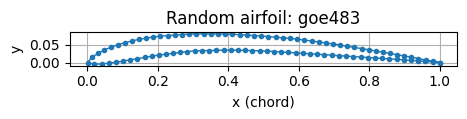

In [3]:
# --- QUICK VISUAL SAMPLER ---------------------------------------------------
# Draw one random airfoil from the merged pickle and plot its geometry.
#
# Prerequisite: airfoil_cvae_dataset.pkl created in Step 2.
# ---------------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt

PKL_PATH = "./airfoil_cvae_dataset.pkl"   # change if you saved elsewhere

# 1.  Load the full dataframe (lazy if already in memory)
df = pd.read_pickle(PKL_PATH)

# 2.  Sample a single row at random
sample = df.sample(1, random_state=None).iloc[0]
name   = sample["airfoil_name"]
geom   = sample["geometry"]      # (100, 2) ndarray

# 3.  Plot
plt.figure(figsize=(5, 4))
plt.plot(geom[:, 0], geom[:, 1], marker="o", markersize=3, linewidth=1)
plt.gca().set_aspect("equal", adjustable="box")
plt.title(f"Random airfoil: {name}")
plt.xlabel("x (chord)")
plt.ylabel("y")
plt.grid(True)
plt.show()


In [8]:
# ===== STEP 3 – GLOBAL NORMALISATION & TORCH DATALOADERS =====================
#
#  ▸ Loads the merged pickle from Step 2
#  ▸ Verifies every value in  [Re, α, Cₗ, C_d, C_m, Cₗ/C_d] is finite
#    – prints how many NaN / ±inf it found and drops those rows
#  ▸ Fits / reloads MinMaxScalers for geometry and numeric conditions
#  ▸ Builds AirfoilDataset + train/val DataLoaders
# ============================================================================

import os, math, joblib, numpy as np, pandas as pd, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# --------------------------------------------------------------------------- #
# CONFIG
PKL_PATH   = Path("./airfoil_cvae_dataset.pkl")
GEOM_SCAL  = Path("./geom_minmax.pkl")
COND_SCAL  = Path("./cond_minmax.pkl")
NUM_COLS   = ["reynolds_number", "angle_of_attack",
              "cl", "cd", "cm", "cl_cd_ratio"]

BATCH_SIZE   = 256
NUM_WORKERS  = min(8, os.cpu_count())

# --------------------------------------------------------------------------- #
# 1. LOAD DATAFRAME
df = pd.read_pickle(PKL_PATH)

# --------------------------------------------------------------------------- #
# 2. AUDIT & CLEAN NUMERIC COLUMNS
for col in NUM_COLS:
    df[col] = pd.to_numeric(df[col], errors="coerce")

nonfinite_mask = ~np.isfinite(df[NUM_COLS].values).all(axis=1)
n_bad          = int(nonfinite_mask.sum())

print(f"[audit] Rows in dataframe      : {len(df):,}")
print(f"[audit] Non-finite rows found   : {n_bad}")

if n_bad:
    df = df.loc[~nonfinite_mask].reset_index(drop=True)
    print(f"[clean] Dropped {n_bad} rows with NaN/±inf.")

# --------------------------------------------------------------------------- #
# 3. FIT / LOAD GLOBAL SCALERS
# --- geometry ---------------------------------------------------------------
if GEOM_SCAL.exists():
    geom_scaler = joblib.load(GEOM_SCAL)
else:
    geom_mat    = np.vstack(df["geometry"].apply(lambda g: g.flatten()).values)
    geom_scaler = MinMaxScaler().fit(geom_mat)
    joblib.dump(geom_scaler, GEOM_SCAL)
    print("[save] geom_minmax.pkl written.")

# --- numeric condition ------------------------------------------------------
if COND_SCAL.exists():
    cond_scaler = joblib.load(COND_SCAL)
else:
    cond_scaler = MinMaxScaler().fit(df[NUM_COLS].values)
    joblib.dump(cond_scaler, COND_SCAL)
    print("[save] cond_minmax.pkl written.")

# --------------------------------------------------------------------------- #
# 4. TORCH DATASET
class AirfoilDataset(Dataset):
    """Yield (geometry, condition, aero) tensors ready for the β-CVAE."""
    def __init__(self, frame, geom_scaler, cond_scaler,n_ids_total, one_hot=True):
        self.df            = frame.reset_index(drop=True)
        self.geom_scaler   = geom_scaler
        self.cond_scaler   = cond_scaler
        self.one_hot       = one_hot
        self.n_ids         = n_ids_total          # << fixed

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # -- geometry (1 × 200) ---------------------------------------------
        g = row["geometry"].flatten()[None, :]
        g = self.geom_scaler.transform(g).astype(np.float32)

        # -- numeric conditioning (min-maxed) -------------------------------
        num = row[NUM_COLS].values.reshape(1, -1)
        num = self.cond_scaler.transform(num).astype(np.float32).squeeze(0)

        # -- ID → one-hot ----------------------------------------------------
        if self.one_hot:
            id_vec = np.zeros(self.n_ids, dtype=np.float32)
            id_vec[row["airfoil_id"]] = 1.0
            cond = np.concatenate([num, id_vec])
        else:
            cond = np.concatenate([num, [row["airfoil_id"]]], axis=0)

        # -- tensors ---------------------------------------------------------
        geom_t = torch.from_numpy(g)          # (1, 200)
        cond_t = torch.from_numpy(cond)       # (6 + N_ids)
        aero_t = torch.from_numpy(num.copy()) # (6,)

        return geom_t, cond_t, aero_t

# --------------------------------------------------------------------------- #
# 5. TRAIN / VAL SPLIT + DATALOADERS
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, shuffle=True)
N_IDS_TOTAL = int(df["airfoil_id"].max()) + 1   # 1647
train_loader = DataLoader(
    AirfoilDataset(train_df, geom_scaler, cond_scaler, n_ids_total=N_IDS_TOTAL),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)

val_loader = DataLoader(
    AirfoilDataset(val_df, geom_scaler, cond_scaler, n_ids_total=N_IDS_TOTAL),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

# --------------------------------------------------------------------------- #
# 6. QUICK SHAPE CHECK
g, c, a = next(iter(train_loader))
print(f"\ngeometry batch : {tuple(g.shape)}")   # (B, 1, 200)
print(f"condition batch: {tuple(c.shape)}")    # (B, 6 + one-hot)
print(f"aero batch     : {tuple(a.shape)}")    # (B, 6)


[audit] Rows in dataframe      : 494,100
[audit] Non-finite rows found   : 300
[clean] Dropped 300 rows with NaN/±inf.

geometry batch : (256, 1, 200)
condition batch: (256, 1653)
aero batch     : (256, 6)


In [10]:
# ===== STEP 4 – β-CVAE MODEL & TRAINING LOOP ==================================
#
#  • Defines a LightningModule  (BetaCVAE)
#  • Uses the DataLoaders from Step 3  (train_loader, val_loader)
#  • Tracks val_loss with EarlyStopping + ModelCheckpoint
#  • Logs progress every epoch
# ============================================================================

import torch, torch.nn as nn, torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# --------------------------------------------------------------------------- #
# 1.  Fetch dims from the dataset
n_ids       = train_loader.dataset.n_ids          # 1 647 in your case
cond_dim    = 6 + n_ids                           # 6 numerics + one-hot IDs
geo_dim     = 200                                 # (1 × 200) flattened outline
latent_dim  = 32

beta = 1e-3     # weight on KLD
lam  = 0.1      # weight on aero MSE

# --------------------------------------------------------------------------- #
# 2.  β-CVAE MODEL
class BetaCVAE(pl.LightningModule):
    def __init__(self, geo_dim, cond_dim, latent_dim, beta=1e-3, lam=0.1):
        super().__init__()
        self.save_hyperparameters()

        # ----- encoder ------------------------------------------------------
        self.enc = nn.Sequential(
            nn.Linear(geo_dim, 256), nn.GELU(),
            nn.Linear(256, 128),     nn.GELU()
        )
        self.fc_mu     = nn.Linear(128 + cond_dim, latent_dim)
        self.fc_logvar = nn.Linear(128 + cond_dim, latent_dim)

        # ----- decoder – geometry branch -----------------------------------
        self.dec_geo = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 128), nn.GELU(),
            nn.Linear(128, 256),            nn.GELU(),
            nn.Linear(256, geo_dim)                     # → (200,)
        )

        # ----- decoder – aero regressor branch -----------------------------
        self.dec_aero = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 64), nn.GELU(),
            nn.Linear(64, 6)                                # → (6,)
        )

    # --- reparametrisation trick -------------------------------------------
    def _sample_z(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # -----------------------------------------------------------------------
    def forward(self, geo, cond):
        # geo : (B, 1, 200)  → flatten
        geo_flat = geo.view(geo.size(0), -1)
        h        = self.enc(geo_flat)
        h_cond   = torch.cat([h, cond], dim=1)

        mu, logvar = self.fc_mu(h_cond), self.fc_logvar(h_cond)
        z          = self._sample_z(mu, logvar)

        z_cond = torch.cat([z, cond], dim=1)
        geo_hat  = self.dec_geo(z_cond)
        aero_hat = self.dec_aero(z_cond)
        return geo_hat, aero_hat, mu, logvar

    # -----------------------------------------------------------------------
    def step(self, batch, stage="train"):
        geo, cond, aero = batch  # geo:(B,1,200)  cond:(B,cond_dim)
        geo_hat, aero_hat, mu, logvar = self(geo, cond)

        # losses
        mse_geo  = F.mse_loss(geo_hat, geo.view(geo.size(0), -1))
        mse_aero = F.mse_loss(aero_hat, aero)
        kld      = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss     = mse_geo + self.hparams.beta * kld + self.hparams.lam * mse_aero

        self.log(f"{stage}_loss", loss,     prog_bar=True)
        self.log(f"{stage}_mse_geo",  mse_geo)
        self.log(f"{stage}_mse_aero", mse_aero)
        self.log(f"{stage}_kld",      kld)
        return loss

    def training_step(self, batch, _):      return self.step(batch, "train")
    def validation_step(self, batch, _):    self.step(batch, "val")

    # -----------------------------------------------------------------------
    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=1e-3)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20, eta_min=1e-5)
        return {"optimizer": opt, "lr_scheduler": sch}

# --------------------------------------------------------------------------- #
# 3.  INSTANTIATE MODEL
model = BetaCVAE(geo_dim=geo_dim,
                 cond_dim=cond_dim,
                 latent_dim=latent_dim,
                 beta=beta, lam=lam)

# --------------------------------------------------------------------------- #
# 4.  TRAINER SETUP
early_stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
chkpt      = ModelCheckpoint(monitor="val_loss",
                             filename="beta-cvae-{epoch:02d}-{val_loss:.4f}",
                             save_top_k=3, mode="min")

trainer = pl.Trainer(
    max_epochs=200,
    accelerator="auto", devices="auto",
    callbacks=[early_stop, chkpt],
    log_every_n_steps=50,
)

# --------------------------------------------------------------------------- #
# 5.  KICK OFF TRAINING
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | enc       | Sequential | 84.4 K | train
1 | fc_mu     | Linear     | 57.0 K | train
2 | fc_logvar | Linear     | 57.0 K | train
3 | dec_geo   | Sequential | 300 K  | train
4 | dec_aero  | Sequential | 108 K  | train
-------------------------------------------------
606 K     Trainable params
0         Non-trainable params
606 K     Total params
2.428     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Epoch 30: 100%|██████████| 1736/1736 [00:25<00:00, 67.85it/s, v_num=7, train_loss=1.01e-6, val_loss=1.49e-6] 


Top-5 MSE in latent samples : [0.00027761 0.00027765 0.00027771 0.00027777 0.00027789]
Saved: ['1_spec1.dat', '1_spec2.dat', '1_spec3.dat', '1_spec4.dat', '1_spec5.dat']


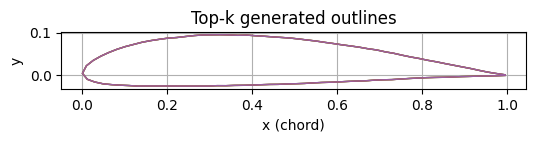

In [30]:
# ===== STEP 5 – INFERENCE: SPEC → SYNTHETIC AIRFOILS ==========================
#
#  Prereq:
#    • geom_scaler.pkl, cond_scaler.pkl          (from Step 3)
#    • Trained checkpoint 'best.ckpt'            (from Step 4)
#    • BetaCVAE class definition in scope
#
#  Usage:
#    1.  edit TARGET_SPEC dict below
#    2.  run the cell  →  you'll get k best .dat files + a preview plot
# ============================================================================

import torch, numpy as np, joblib, os, matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------------------- #
# CONFIG
CHECKPOINT = "./lightning_logs/version_7/checkpoints/beta-cvae-epoch=22-val_loss=0.0000.ckpt"  # <— EDIT
GEOM_SCAL  = "./geom_minmax.pkl"
COND_SCAL  = "./cond_minmax.pkl"
N_IDS      = 1_647                 # total vocabulary size
N_SAMPLES  = 40                    # latents drawn per request
TOP_K      = 5                     # how many .dat files to save

TARGET_SPEC = dict(
    reynolds_number = 1_000_000.0,
    angle_of_attack = 10,
    cl              = -0.594563,
    cd              = 0.11717592,
    cm              = -0.07,
    cl_cd_ratio     = 92.0,
    airfoil_id      = 1          # can be any valid int (0‒1646); 0 is fine
)
OUT_DIR = Path("./generated_airfoils")
OUT_DIR.mkdir(exist_ok=True)

# --------------------------------------------------------------------------- #
# 1. LOAD SCALERS & MODEL
geom_scaler = joblib.load(GEOM_SCAL)
cond_scaler = joblib.load(COND_SCAL)

model = BetaCVAE.load_from_checkpoint(CHECKPOINT)
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------------------------------------------------------- #
# 2. HELPERS
NUM_COLS = ["reynolds_number", "angle_of_attack",
            "cl", "cd", "cm", "cl_cd_ratio"]

def spec_to_cond(spec, one_hot=True):
    """Build the condition vector (min-maxed numerics + one-hot ID)."""
    num = np.array([[spec[c] for c in NUM_COLS]], dtype=np.float32)
    num = cond_scaler.transform(num).squeeze(0)
    if one_hot:
        id_vec = np.zeros(N_IDS, dtype=np.float32)
        id_vec[spec["airfoil_id"]] = 1.0
        cond = np.concatenate([num, id_vec])
    else:
        cond = np.concatenate([num, [spec["airfoil_id"]]], axis=0)
    return torch.from_numpy(cond).unsqueeze(0)

def write_dat(name, xy):
    """Save 100-point outline to <name>.dat in XFOIL style."""
    with open(name, "w") as f:
        f.write(Path(name).stem + "\n")
        for x, y in xy:
            f.write(f"{x:.6f}  {y:.6f}\n")

# --------------------------------------------------------------------------- #
# 3. BUILD CONDITION TENSOR
cond = spec_to_cond(TARGET_SPEC, one_hot=True).to(model.device)

# --------------------------------------------------------------------------- #
# 4. SAMPLE LATENTS & DECODE
with torch.no_grad():
    z = torch.randn(N_SAMPLES, model.hparams.latent_dim, device=model.device)
    cond_rep = cond.repeat(N_SAMPLES, 1)
    geo_hat, aero_hat, *_ = model.dec_geo(torch.cat([z, cond_rep], dim=1)), \
                            model.dec_aero(torch.cat([z, cond_rep], dim=1))

    # → geo_hat : (N, 200)  – rescale back to real coords
    geo_np = geom_scaler.inverse_transform(geo_hat.cpu().numpy())
    geo_np = geo_np.reshape(N_SAMPLES, 100, 2)

    # → aero_hat : (N, 6)   – compare to target (already min-maxed)
    target_norm = cond_scaler.transform(
        np.array([[TARGET_SPEC[c] for c in NUM_COLS]], dtype=np.float32)
    ).squeeze(0)
    err = ((aero_hat.cpu().numpy() - target_norm) ** 2).mean(axis=1)

# --------------------------------------------------------------------------- #
# 5. SELECT TOP-K BY AERO ERROR
top_idx = np.argsort(err)[:TOP_K]
print(f"Top-{TOP_K} MSE in latent samples :", err[top_idx])

files = []
for rank, i in enumerate(top_idx, 1):
    xy = geo_np[i]
    fname = OUT_DIR / f"{TARGET_SPEC['airfoil_id']}_spec{rank}.dat"
    write_dat(fname, xy)
    files.append(fname.name)

print("Saved:", files)

# --------------------------------------------------------------------------- #
# 6. QUICK PLOT
plt.figure(figsize=(6, 4))
for i in top_idx:
    plt.plot(geo_np[i][:,0], geo_np[i][:,1], linewidth=1, alpha=0.8)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Top-k generated outlines")
plt.xlabel("x (chord)"); plt.ylabel("y"); plt.grid(True)
plt.show()


Selected top 5 (lowest aero-MSE): [6.9814973e-06 7.0541942e-06 7.5696457e-06 8.0526934e-06 8.1531189e-06]
Saved: ['spec_01.dat', 'spec_02.dat', 'spec_03.dat', 'spec_04.dat', 'spec_05.dat']


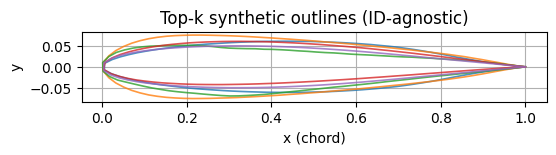

In [ ]:
# ===== STEP 5 – ID-AGNOSTIC INFERENCE ========================================
#
#  • Uses the same BetaCVAE checkpoint
#  • Fills the 1-hot ID vector with zeros (or random IDs) so the model must
#    rely on the latent z to satisfy the aero spec.
# ============================================================================

import torch, numpy as np, joblib, matplotlib.pyplot as plt
from pathlib import Path

# --------------------------------------------------------------------------- #
# CONFIG
CHECKPOINT = "./lightning_logs/version_7/checkpoints/beta-cvae-epoch=22-val_loss=0.0000.ckpt"
GEOM_SCAL  = "./geom_minmax.pkl"
COND_SCAL  = "./cond_minmax.pkl"

N_IDS      = 1_647          # full one-hot length (unchanged)
N_SAMPLES  = 60             # how many latents to draw
TOP_K      = 5              # .dat files to keep
ID_MODE    = "random"         # "zero" | "random"  (« same » reproduces)

TARGET_SPEC = dict(
    reynolds_number = 1_000_000.0,
    angle_of_attack = 10.0,
    cl              = 0.6999,
    cd              = 0.01932,
    cm              = -0.1328,
    cl_cd_ratio     = -2.73121143
)

OUT_DIR = Path("./generated_airfoilsv2"); OUT_DIR.mkdir(exist_ok=True)

# --------------------------------------------------------------------------- #
# LOAD SCALERS & MODEL
geom_scaler = joblib.load(GEOM_SCAL)
cond_scaler = joblib.load(COND_SCAL)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = BetaCVAE.load_from_checkpoint(CHECKPOINT, map_location=device).eval()

NUM_COLS = ["reynolds_number", "angle_of_attack",
            "cl", "cd", "cm", "cl_cd_ratio"]

# --------------------------------------------------------------------------- #
# BUILD CONDITION MATRIX  (N_SAMPLES × cond_dim)
num_base = cond_scaler.transform(
    np.array([[TARGET_SPEC[c] for c in NUM_COLS]], dtype=np.float32)
).squeeze(0)

if ID_MODE == "zero":
    ids = np.zeros((N_SAMPLES, N_IDS), dtype=np.float32)
elif ID_MODE == "random":
    ids = np.zeros((N_SAMPLES, N_IDS), dtype=np.float32)
    rand_idx = np.random.randint(0, N_IDS, size=N_SAMPLES)
    ids[np.arange(N_SAMPLES), rand_idx] = 1.0
else:  # reproducible / legacy: give a fixed ID
    ids = np.zeros((N_SAMPLES, N_IDS), dtype=np.float32)
    ids[:, TARGET_SPEC.get("airfoil_id", 0)] = 1.0

cond_mat = np.hstack([np.repeat(num_base[None, :], N_SAMPLES, axis=0), ids])
cond_t   = torch.from_numpy(cond_mat).to(device)

# --------------------------------------------------------------------------- #
# SAMPLE & DECODE
with torch.no_grad():
    z = torch.randn(N_SAMPLES, model.hparams.latent_dim, device=device)
    geo_norm = model.dec_geo(torch.cat([z, cond_t], dim=1)).cpu().numpy()
    aero_hat = model.dec_aero(torch.cat([z, cond_t], dim=1)).cpu().numpy()

geo = geom_scaler.inverse_transform(geo_norm).reshape(N_SAMPLES, 100, 2)

# --------------------------------------------------------------------------- #
# SCORE BY AERO-ERROR (min-maxed MSE)
target_norm = num_base
err = ((aero_hat - target_norm) ** 2).mean(axis=1)
top_idx = np.argsort(err)[:TOP_K]

print(f"Selected top {TOP_K} (lowest aero-MSE):", err[top_idx])

# --------------------------------------------------------------------------- #
# SAVE & PLOT
def write_dat(path, xy):
    with open(path, "w") as f:
        f.write(path.stem + "\n")
        for x, y in xy: f.write(f"{x:.6f} {y:.6f}\n")

saved = []
for rank, i in enumerate(top_idx, 1):
    fname = OUT_DIR / f"spec_{rank:02d}.dat"
    write_dat(fname, geo[i])
    saved.append(fname.name)

print("Saved:", saved)

plt.figure(figsize=(6,4))
for i in top_idx:
    plt.plot(geo[i,:,0], geo[i,:,1], linewidth=1.2, alpha=0.8)
plt.gca().set_aspect("equal", adjustable="box")
plt.title("Top-k synthetic outlines (ID-agnostic)")
plt.xlabel("x (chord)"); plt.ylabel("y"); plt.grid(True)
plt.show()


In [38]:
# %% [markdown]
# # STEP 6 – NeuralFoil post-check for synthetic airfoils
# This cell
# 1. loads every `.dat` just created in `./generated_airfoils`
# 2. runs NeuralFoil at several Reynolds numbers & AoA sweep
# 3. saves the results to `synthetic_neuralfoil_results.csv`
# Adapt `GEN_FOLDER`, `RE_LIST`, or `ALPHA_RANGE` as needed.

# %%------------------------------------------------------ CONFIG ----------
GEN_FOLDER   = "./generated_airfoilsv2"            # where your *.dat came from
OUT_CSV      = "./synthetic_neuralfoil_results.csv"
RE_LIST      = [1e5, 5e5, 1e6]                   # Reynolds numbers to test
ALPHA_RANGE  = (-8, 12, 2)                       # start, stop, step  (deg)
MODEL_SIZE   = "large"                           # NeuralFoil model variant
# -------------------------------------------------------------------------

import os, warnings, numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
import neuralfoil as nf
warnings.filterwarnings("ignore")

# ---------- helpers --------------------------------------------------------
def load_airfoil_coordinates(dat_path: Path):
    try:
        arr = np.loadtxt(dat_path, skiprows=1)
        return arr[:, 0], arr[:, 1]
    except Exception:
        try:
            arr = np.loadtxt(dat_path)
            return arr[:, 0], arr[:, 1]
        except Exception as e:
            print(f"[load] {dat_path.name}: {e}")
            return None, None

def analyze_airfoil(x, y, Re_list, alpha_rng, model_size=MODEL_SIZE):
    alphas = np.arange(*alpha_rng)
    results = []
    for Re in Re_list:
        for alpha in alphas:
            try:
                aero = nf.get_aero_from_coordinates(
                    np.column_stack([x, y]), alpha=alpha, Re=Re,
                    model_size=model_size
                )
                results.append(dict(
                    reynolds_number = Re,
                    angle_of_attack = alpha,
                    cl             = aero["CL"],
                    cd             = aero["CD"],
                    cm             = aero["CM"],
                    cl_cd_ratio    = aero["CL"] / aero["CD"] if aero["CD"] else np.inf
                ))
            except Exception as e:
                print(f"[aero] Re={Re} α={alpha}: {e}")
    return results

def process_folder(folder, out_csv, Re_list, alpha_rng):
    dat_files = list(Path(folder).glob("*.dat"))
    if not dat_files:
        print(f"No .dat files in {folder}")
        return None

    all_rows = []
    for dat in tqdm(dat_files, desc="NeuralFoil"):
        x, y = load_airfoil_coordinates(dat)
        if x is None: continue

        rows = analyze_airfoil(x, y, Re_list, alpha_rng)
        for r in rows:
            r.update(airfoil_name=dat.stem, airfoil_file=dat.name)
        all_rows.extend(rows)

    if not all_rows:
        print("Nothing processed – check .dat files or NeuralFoil install.")
        return None

    df = pd.DataFrame(all_rows).sort_values(
            ["airfoil_name", "reynolds_number", "angle_of_attack"])
    df.to_csv(out_csv, index=False)
    print(f"\nSaved {len(df):,} rows → {out_csv}")
    return df

# ---------- run ------------------------------------------------------------
print(f"Folder : {GEN_FOLDER}\nOutput : {OUT_CSV}")
df_syn = process_folder(GEN_FOLDER, OUT_CSV, RE_LIST, ALPHA_RANGE)

if df_syn is not None:
    display(df_syn.head())


Epoch 2:  24%|██▍       | 413/1736 [42:26<2:15:56,  0.16it/s, v_num=6, train_loss=4.51e-6, val_loss=6.28e-6]

Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



Folder : ./generated_airfoilsv2
Output : ./synthetic_neuralfoil_results.csv


NeuralFoil: 100%|██████████| 5/5 [00:00<00:00, 19.89it/s]


Saved 150 rows → ./synthetic_neuralfoil_results.csv


,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio,airfoil_name,airfoil_file
30,100000.0,-8,[-0.63618997648742],[0.06125583639172181],[-0.03192411394652602],[-10.385785485305945],spec_01,spec_01.dat
31,100000.0,-6,[-0.6707752453227724],[0.04148349128547926],[-0.008268926138041713],[-16.169691232270228],spec_01,spec_01.dat
32,100000.0,-4,[-0.5348980504685118],[0.02693891955254752],[0.0046016582963275725],[-19.855957824334062],spec_01,spec_01.dat
33,100000.0,-2,[-0.3332229573143718],[0.021986728520099082],[0.02113892996648399],[-15.155640686141975],spec_01,spec_01.dat
34,100000.0,0,[-0.0645361717833503],[0.016318295332024616],[0.01591879883130621],[-3.95483538385889],spec_01,spec_01.dat


In [51]:
# %% [markdown]
# ### STEP 7 – Compare NeuralFoil output to target spec

# %%------------------------------------------------------- CONFIG ----------
NF_CSV      = "./synthetic_neuralfoil_results.csv"  # path from STEP 6
TARGET_SPEC = dict(
    reynolds_number = 1_000_000.0,
    angle_of_attack = 10.0,
    cl              = -0.594563,
    cd              = 0.11717592,
    cm              = -0.070,
    cl_cd_ratio     = 92.0
)
# -------------------------------------------------------------------------

import pandas as pd, numpy as np

# 1. LOAD CSV
df_nf = pd.read_csv(NF_CSV)

# 2. CLEAN columns that still look like "[0.352]"
num_cols = ["cl", "cd", "cm", "cl_cd_ratio"]
for col in num_cols:
    df_nf[col] = (
        df_nf[col]
        .astype(str)
        .str.replace(r"[\[\]]", "", regex=True)   # remove brackets
        .astype(float)
    )

# 3. FILTER to the exact Re & α of interest
mask = (
    (np.isclose(df_nf["reynolds_number"], TARGET_SPEC["reynolds_number"])) &
    (np.isclose(df_nf["angle_of_attack"], TARGET_SPEC["angle_of_attack"]))
)
df_sel = df_nf.loc[mask].copy()

if df_sel.empty:
    print("⚠️  No NeuralFoil rows match the target Re & α.")
else:
    # 4. COMPUTE ERRORS
    for k in num_cols:
        df_sel[f"abs_err_{k}"] = (df_sel[k] - TARGET_SPEC[k]).abs()
        df_sel[f"pct_err_{k}"] = df_sel[f"abs_err_{k}"] / abs(TARGET_SPEC[k]) * 100

    # Composite score: mean of abs-errors (scale-invariant)
    df_sel["score"] = df_sel[[f"abs_err_{k}" for k in num_cols]].mean(axis=1)

    # 5. SORT best → worst and display
    df_best = df_sel.sort_values("score").reset_index(drop=True)
    display(df_best.head(10)[[
        "airfoil_name", "reynolds_number", "angle_of_attack",
        *num_cols, *[f"abs_err_{k}" for k in num_cols], "score"
    ]].style.format({col:"{:.5f}" for col in num_cols + [f"abs_err_{k}" for k in num_cols]}))

    print(f"\nTop match: {df_best.iloc[0]['airfoil_name']}  (score ≈ {df_best.iloc[0]['score']:.5f})")

weights = dict(cl=1.0, cd=10.0, cm=5.0, cl_cd_ratio=0.1)  # example

df_sel["score_w"] = (
      weights["cl"]  * df_sel["abs_err_cl"]
    + weights["cd"]  * df_sel["abs_err_cd"]
    + weights["cm"]  * df_sel["abs_err_cm"]
    + weights["cl_cd_ratio"] * df_sel["abs_err_cl_cd_ratio"]
)
df_best_w = df_sel.sort_values("score_w").reset_index(drop=True)
display(df_best_w.head(10)[[
    "airfoil_name", "reynolds_number", "angle_of_attack",
    *num_cols, *[f"abs_err_{k}" for k in num_cols], "score_w"
]].style.format({col:"{:.5f}" for col in num_cols + [f"abs_err_{k}" for k in num_cols]}))

print(f"\nTop match w: {df_best_w.iloc[0]['airfoil_name']}  (score ≈ {df_best_w.iloc[0]['score_w']:.5f})")


,airfoil_name,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio,abs_err_cl,abs_err_cd,abs_err_cm,abs_err_cl_cd_ratio,score
0,spec_04,1000000.000000,10,1.11643,0.02006,-0.00790,55.65799,1.71100,0.09712,0.06210,36.34201,9.553057
1,spec_02,1000000.000000,10,1.05106,0.02035,0.01403,51.64640,1.64563,0.09682,0.08403,40.35360,10.545022
2,spec_03,1000000.000000,10,0.74373,0.04576,0.02440,16.25140,1.33829,0.07141,0.09440,75.74860,19.313176
3,spec_05,1000000.000000,10,0.64323,0.09213,-0.00963,6.98184,1.23779,0.02505,0.06037,85.01816,21.585341
4,spec_01,1000000.000000,10,0.63023,0.09248,0.01016,6.81452,1.22479,0.02469,0.08016,85.18548,21.628780



Top match: spec_04  (score ≈ 9.55306)


,airfoil_name,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio,abs_err_cl,abs_err_cd,abs_err_cm,abs_err_cl_cd_ratio,score_w
0,spec_04,1000000.000000,10,1.11643,0.02006,-0.00790,55.65799,1.71100,0.09712,0.06210,36.34201,6.626882
1,spec_02,1000000.000000,10,1.05106,0.02035,0.01403,51.64640,1.64563,0.09682,0.08403,40.35360,7.069398
2,spec_03,1000000.000000,10,0.74373,0.04576,0.02440,16.25140,1.33829,0.07141,0.09440,75.74860,10.099262
3,spec_05,1000000.000000,10,0.64323,0.09213,-0.00963,6.98184,1.23779,0.02505,0.06037,85.01816,10.291934
4,spec_01,1000000.000000,10,0.63023,0.09248,0.01016,6.81452,1.22479,0.02469,0.08016,85.18548,10.391075



Top match w: spec_04  (score ≈ 6.62688)


In [52]:
# ---------------------------------------------------------------------------
# 1)  Make sure pct_err_* columns exist
# ---------------------------------------------------------------------------
for k in num_cols:
    abs_col = f"abs_err_{k}"
    pct_col = f"pct_err_{k}"
    if pct_col not in df_sel.columns:
        # avoid division by zero
        tgt_val = TARGET_SPEC[k]
        df_sel[pct_col] = df_sel[abs_col] / abs(tgt_val) * 100.0

# ---------------------------------------------------------------------------
# 2)  Weighted score (unchanged)
# ---------------------------------------------------------------------------
weights = dict(cl=1.0, cd=10.0, cm=5.0, cl_cd_ratio=0.1)
df_sel["score_w"] = (
      weights["cl"]  * df_sel["abs_err_cl"]
    + weights["cd"]  * df_sel["abs_err_cd"]
    + weights["cm"]  * df_sel["abs_err_cm"]
    + weights["cl_cd_ratio"] * df_sel["abs_err_cl_cd_ratio"]
)

df_best_w = df_sel.sort_values("score_w").reset_index(drop=True)

# ---------------------------------------------------------------------------
# 3)  Build a column list that also shows pct errors
# ---------------------------------------------------------------------------
cols_show = (
    ["airfoil_name", "reynolds_number", "angle_of_attack"]
    + num_cols
    + [f"abs_err_{k}" for k in num_cols]
    + [f"pct_err_{k}" for k in num_cols]
    + ["score_w"]
)

fmt = { c : "{:.5f}" for c in num_cols + [f"abs_err_{k}" for k in num_cols] }
fmt.update({ f"pct_err_{k}" : "{:.2f} %" for k in num_cols })   # percentage format

display(
    df_best_w.head(10)[cols_show]
    .style.format(fmt)
)

print(f"\nTop match (w-score): {df_best_w.iloc[0]['airfoil_name']}  "
      f"(score ≈ {df_best_w.iloc[0]['score_w']:.5f})")


,airfoil_name,reynolds_number,angle_of_attack,cl,cd,cm,cl_cd_ratio,abs_err_cl,abs_err_cd,abs_err_cm,abs_err_cl_cd_ratio,pct_err_cl,pct_err_cd,pct_err_cm,pct_err_cl_cd_ratio,score_w
0,spec_04,1000000.000000,10,1.11643,0.02006,-0.00790,55.65799,1.71100,0.09712,0.06210,36.34201,287.77 %,82.88 %,88.72 %,39.50 %,6.626882
1,spec_02,1000000.000000,10,1.05106,0.02035,0.01403,51.64640,1.64563,0.09682,0.08403,40.35360,276.78 %,82.63 %,120.05 %,43.86 %,7.069398
2,spec_03,1000000.000000,10,0.74373,0.04576,0.02440,16.25140,1.33829,0.07141,0.09440,75.74860,225.09 %,60.94 %,134.85 %,82.34 %,10.099262
3,spec_05,1000000.000000,10,0.64323,0.09213,-0.00963,6.98184,1.23779,0.02505,0.06037,85.01816,208.18 %,21.38 %,86.24 %,92.41 %,10.291934
4,spec_01,1000000.000000,10,0.63023,0.09248,0.01016,6.81452,1.22479,0.02469,0.08016,85.18548,206.00 %,21.07 %,114.52 %,92.59 %,10.391075



Top match (w-score): spec_04  (score ≈ 6.62688)


<>:43: SyntaxWarning: invalid escape sequence '\g'
<>:43: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Muhamemd Emin ONAY\AppData\Local\Temp\ipykernel_4104\1320205084.py:43: SyntaxWarning: invalid escape sequence '\g'
  dat_file = '.\generated_airfoilsv2\spec_05.dat'


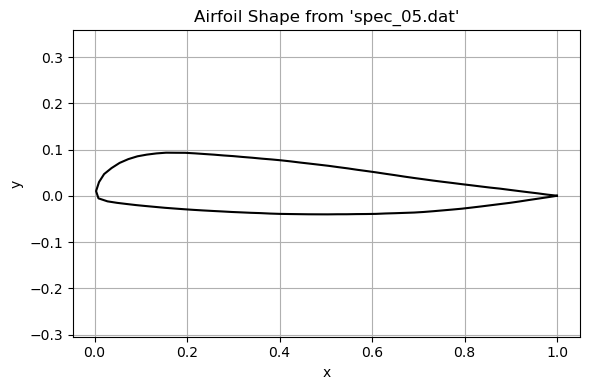

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_airfoil(dat_path):
    """
    Reads an airfoil .dat file (x–y coordinates) and plots its shape.
    Supports files with or without a header line.
    """
    if not os.path.isfile(dat_path):
        raise FileNotFoundError(f"No such file: {dat_path}")

    # Try to load, skipping a possible header line if it isn’t numeric
    try:
        # First attempt: assume first row is a header (e.g. “NACA2412”)
        data = np.loadtxt(dat_path, skiprows=1)
        # If that succeeded but the first row was not numeric, data will have two columns
        if data.ndim != 2 or data.shape[1] < 2:
            raise ValueError
    except (ValueError, IndexError):
        # Fallback: load everything as numeric
        data = np.loadtxt(dat_path)
    x, y = data[:, 0], data[:, 1]

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, "k-", linewidth=1.5)
    plt.axis("equal")
    plt.title(f"Airfoil Shape from '{os.path.basename(dat_path)}'")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    import sys

    if len(sys.argv) != 2:
        print("Usage: python plot_airfoil.py <path_to_airfoil.dat>")
        sys.exit(1)

    dat_file = '.\generated_airfoilsv2\spec_05.dat'
    plot_airfoil(dat_file)
